## Benchmarking

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("Rtian/DebugBench")
# Print out some information about the dataset
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['release_time', 'examples', 'bug_explanation', 'category', 'slug', 'solution', 'buggy_code', 'solution_explanation', 'question', 'level', 'language', 'subtype', 'constraints'],
        num_rows: 4253
    })
})


In [3]:
import difflib

def remove_blank_lines(text):
    return "\n".join([s for s in text.splitlines() if s])

def custom_diff(file1_contents, file2_contents):
    diff = difflib.ndiff(file1_contents.splitlines(), file2_contents.splitlines())
    
    unchanged_lines = []
    old_lines = []
    new_lines = []

    current_line_number = 1
    for line in diff:        
        if line.startswith('  '):
            current_line_number += 1
            continue
        elif line.startswith('- '):  # Lines in file1 but not in file2
            old_lines.append([current_line_number, line[2:]])
            current_line_number += 1        
    return old_lines

solution = """def sum(a, b):
                sum = 0
                return sumum
            """

buggy_code = """def sum(a, b):
                sum = 3
                zzzz
                return sum
            """

#old = custom_diff(buggy_code, solution)
#print(old)

In [4]:
import sys
import subprocess

def format_cpp_code(code):
    try:
        process = subprocess.Popen(['clang-format', '-style=file:./clang-format.txt'], 
                                   stdin=subprocess.PIPE, 
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.PIPE)
        formatted_code, errors = process.communicate(input=code.encode())
        
        if process.returncode != 0:
            print("Error formatting code: ", errors.decode())
            return None
        
        return formatted_code.decode()
    except Exception as e:
        print(f"An exception occurred: {e}")
        return None


In [5]:
def process_result_json(input_json):
    num_line = 1
    current_max_perplexity = 0
    result = []
    for item in input_json:
        num_lines = len(item[1].split("\n")) -1
        if num_lines == 0:
            current_max_perplexity = max(current_max_perplexity, float(item[0]))
        else:
            current_max_perplexity = max(current_max_perplexity, float(item[0]))
            result.append(current_max_perplexity)
            for i in range(num_lines -1):
                result.append(float(item[0]))
            if not item[1].endswith("\n"):
                current_max_perplexity = float(item[0])
            else:
                current_max_perplexity = 0
    return result
        
        
        

In [6]:
import requests as req
counter = 0
counter_multi_diff = 0
buggy_code_list = []
solutions = []
diffs = []
perplexity_per_line = []
for entry in dataset['test']:
    if entry['language'] == 'cpp' and entry['category'] == 'logic error':
        counter += 1
        buggy_code = format_cpp_code(remove_blank_lines(entry['buggy_code']))
        data = {"prompt": buggy_code}
        resp = req.post("http://delos.eaalab.hpi.uni-potsdam.de:8010/highlight-code/", json=data)
        resp_json = resp.json()["generated_text"]
        perplexity_per_line.append(process_result_json(resp_json))
        solution = format_cpp_code(remove_blank_lines(entry['solution']))
        diff = custom_diff(buggy_code, solution)
        solutions.append(solution)
        diffs.append(diff)
        buggy_code_list.append(buggy_code)
        if len(diff) != 1:
        #    print("Buggy Code:")
        #    print(buggy_code)
        #    print("\nSolution:")
        #    print(solution)
        #    print(diff)
        #    print("\n" + "="*40 + "\n")
            counter_multi_diff +=1
print(counter_multi_diff)
print(counter)

45
200


In [7]:
avg_counter = 0
avg_sum = 0
for i in range(len(solutions)):
    diff = diffs[i]
    for item in diff:
        line_number = item[0]
        #if line_number >= len(perplexity_per_line[i]):
        #    print("Alarm")
        #    print(line_number, len(perplexity_per_line[i]))
        #    continue
        #print(perplexity_per_line[i])
        #print(item[1])
        actual_perplexity = perplexity_per_line[i][line_number-1]
        if actual_perplexity != 0:
            counter = 0
            for perplexity in perplexity_per_line[i]:
                if perplexity > actual_perplexity:
                    counter += 1
            percentage = counter / len(perplexity_per_line[i])
            if percentage < 0.2:
                avg_counter += 1
                avg_sum += actual_perplexity
        else:
            print(1)
print(avg_sum / avg_counter)
                    

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0.9285892546505095


In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve


In [9]:
total_num_lines = 0
labels = []
predictions = []
num_positives = 0
for i in range(200):
    current_num_lines = len(perplexity_per_line[i])
    total_num_lines += current_num_lines
    current_labels = [False for _ in range(current_num_lines)]
    for item in diffs[i]:
        line = item[0]
        current_labels[line-1] = True
        num_positives += 1
    predictions.extend(perplexity_per_line[i])
    labels.extend(current_labels)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.7624131335911315
Area 0.8261437275251068


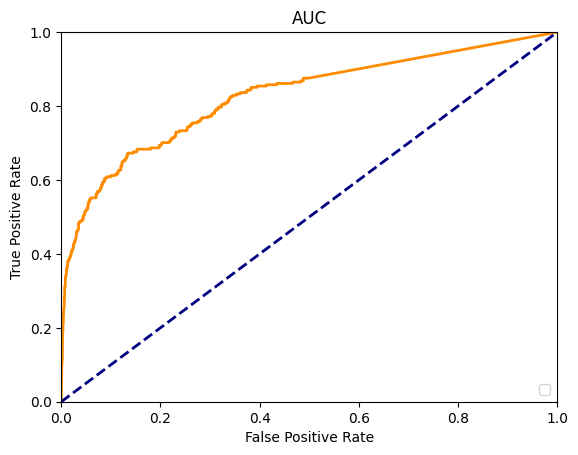

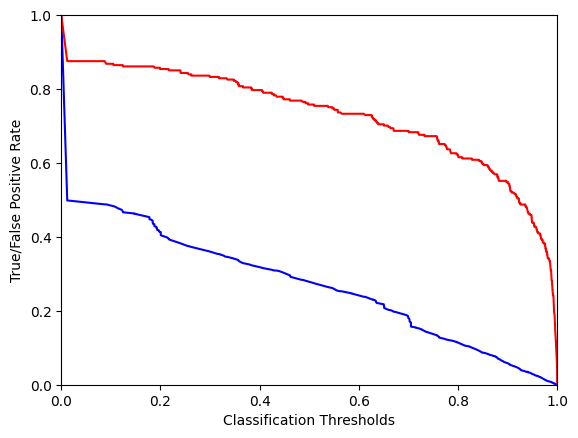

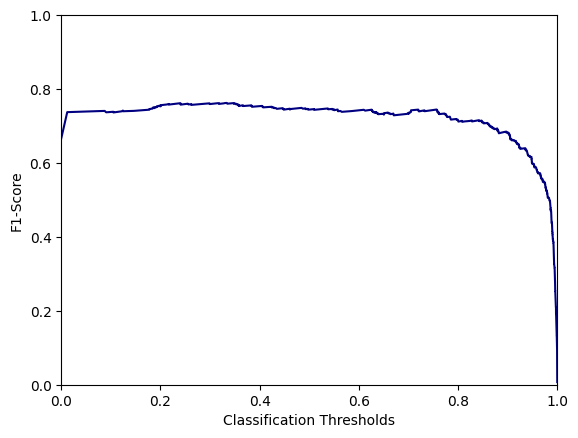

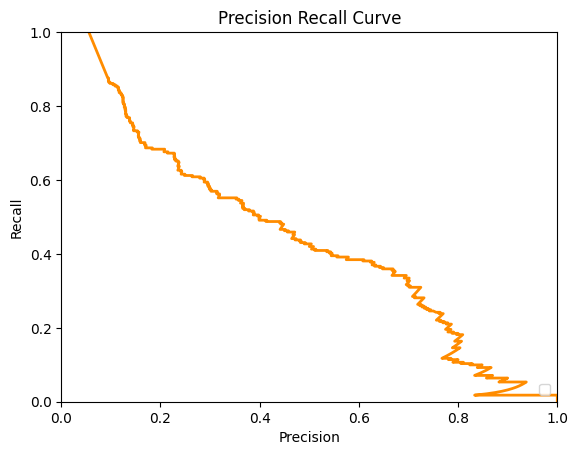

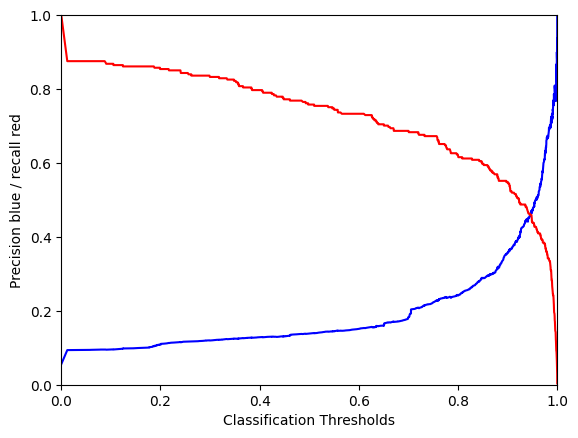

In [13]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels, predictions)
precision, recall, thresholds2 = precision_recall_curve(labels, predictions)
fn = [(num_positives) - tp * num_positives for tp in tpr]
#fnr = [fn/(total_num_lines - num_positives) for fn in fn]
f1 = [(2*tpr[i]*num_positives)/(2*tpr[i]*num_positives + fpr[i]*num_positives + fn[i]) for i in range(len(fpr))]
print(max(f1))

roc_auc = auc(fpr, tpr)
print("Area", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
plt.legend(loc='lower right')

plt.figure()
plt.plot(thresholds, fpr, color='blue')
plt.plot(thresholds, tpr, color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('fpr(blu/False Positive Rate')

plt.figure()
plt.plot(thresholds, f1, color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('F1-Score')

plt.figure()
plt.plot(precision, recall, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.legend(loc='lower right')

plt.figure()
plt.plot(thresholds2, precision[:-1], color='blue')
plt.plot(thresholds2, recall[:-1], color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('Precision blue / recall red')

plt.show()

In [16]:
counter = 0
for code in buggy_code_list:
    counter += 1
    if counter > 5:
        break
    print(code)
    print("-"*40)

class Solution {
   public:
    long long fact(int n) {
        if (n <= 1) return 1;
        return (n * fact(n + 1) % 1000000007) % 1000000007;
    }
    int numPrimeArrangements(int n) {
        if (n == 1) return 1;
        if (n <= 3) return n - 1;
        int t = 0, flag;
        for (int i = 2; i <= n; i++) {
            flag = 0;
            for (int j = 2; j <= sqrt(i); j++) {
                if (i % j == 0) {
                    flag = 1;
                    break;
                }
            }
            if (flag == 0) {
                t++;
            }
        }
        return (fact(t) * fact(n - t)) % 1000000007;
    }
};
----------------------------------------
/**
 * Definition for a binary tree node.
 * struct TreeNode {
 *     int val;
 *     TreeNode *left;
 *     TreeNode *right;
 *     TreeNode() : val(0), left(nullptr), right(nullptr) {}
 *     TreeNode(int x) : val(x), left(nullptr), right(nullptr) {}
 *     TreeNode(int x, TreeNode *left, TreeNode *right) : 

In [17]:
counter = 0
for diff in diffs:
    counter += 1
    if counter > 5:
        break
    print(diff)

[[5, '        return (n * fact(n + 1) % 1000000007) % 1000000007;']]
[[17, '            root->left = mergeTrees(t1->left, t2->right);'], [18, '            root->right = mergeTrees(t1->right, t2->left);']]
[[24, '            sum += max;']]
[[27, '            res = max(res, b[i].second - b[i].first + 1);']]
[[8, '                dp[(i + a) % 3] = max(dp[(i + a) % 3], a);']]
